# Template code for CNN

In this notebook, we will show a simple usage of CNN on the MNIST dataset. 
The usage of GPUs is highly recommended

In [81]:
#!pip install torch==2.4 # Run just once
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from math import floor

# Set torch seed


#  Q1

In [82]:
manual_seed = 42
torch.manual_seed(manual_seed)

In [83]:
torch.randint(1, 10 , (1,1))

tensor([[7]])

se runno di fila le due celle ottengo tensor([[7]]) se runni due volte la seconda tensor([[6]])

# Q2


In [84]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


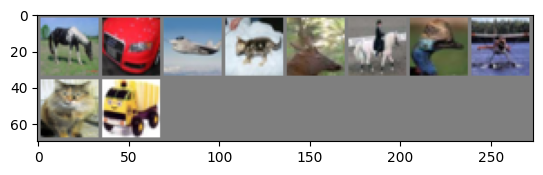

horse car   plane cat   deer  horse bird  plane cat   truck

Showing distribution of classes...


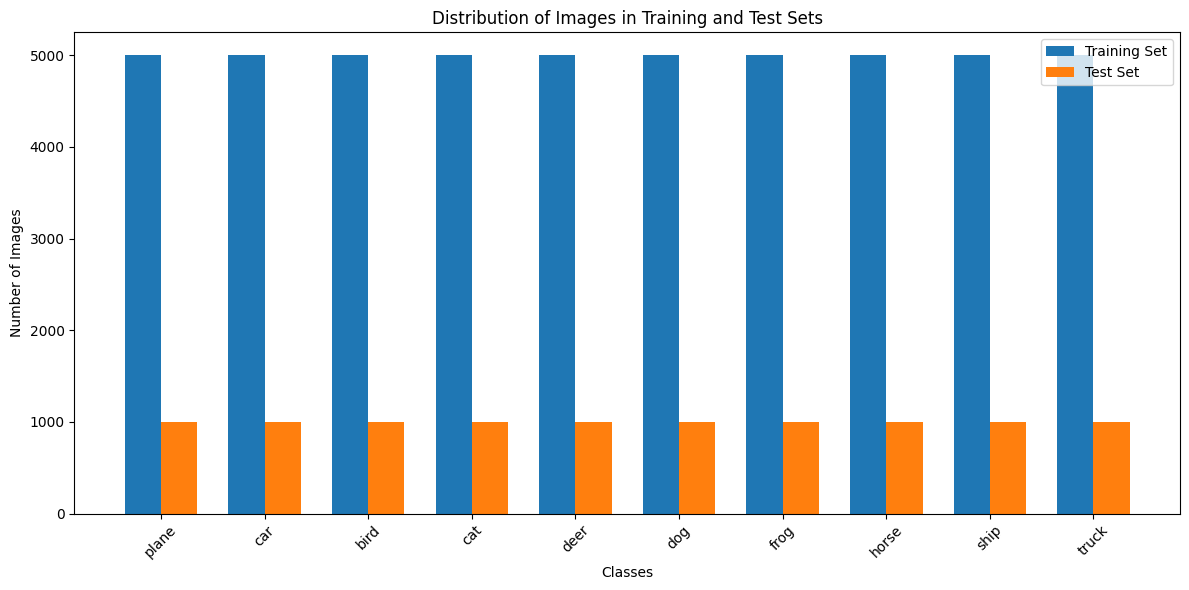

In [85]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(classes))))


# Function to plot distribution histogram
def plot_distribution():
    # Count instances in training set
    train_dist = [0] * 10
    for _, labels in trainloader:
        for label in labels:
            train_dist[label.item()] += 1
            
    # Count instances in test set
    test_dist = [0] * 10
    for _, labels in testloader:
        for label in labels:
            test_dist[label.item()] += 1
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    x = np.arange(len(classes))
    width = 0.35
    
    plt.bar(x - width/2, train_dist, width, label='Training Set')
    plt.bar(x + width/2, test_dist, width, label='Test Set')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images in Training and Test Sets')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\nShowing distribution of classes...")
plot_distribution()




## Model

Define a simple Convolutional neural network having 3 conv + pool layers. As activation function, use ReLu

In [86]:
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        h_out, w_out = out_dimensions(self.conv1, 28, 28)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        self.fc1 = nn.Linear(32 * h_out * w_out, 10)
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x

## Training

In [87]:
model = CNN()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [88]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on mps


In [89]:
# n_epochs = 3
# train_loss_list = []
# validation_loss_list = []
# for epoch in range(n_epochs):
#     loss_train = 0
#     for data, target in train_loader:
#         # Set the model in training mode
#         model.train()
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         # Set the gradient to 0
#         optimizer.zero_grad()
#         # Make a prediction
#         output = model(data)
#         # Compute the loss function
#         loss = loss_fn(output, target)
#         loss_train += loss.item()
#         # Backpropagation
#         loss.backward()
#         # Update parameters
#         optimizer.step()
#     loss_train = loss_train / len(train_loader) # Consider this alternative method of tracking training loss. 
#     train_loss_list.append(loss_train)
    
#     # At the end of every epoch, check the validation loss value
#     with torch.no_grad():
#         model.eval()
#         for data, target in validation_loader: # Just one batch
#             data, target = data.to(DEVICE), target.to(DEVICE)
#             # Make a prediction
#             output = model(data)
#             # Compute the loss function
#             validation_loss = loss_fn(output, target).item()
#             print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
#             validation_loss_list.append(validation_loss)
    

In [90]:
# plt.figure()
# plt.plot(range(n_epochs), train_loss_list)
# plt.plot(range(n_epochs), validation_loss_list)
# plt.legend(["Train loss", "Validation Loss"])
# plt.xlabel("Epochs")
# plt.ylabel("Loss value")
# plt.show()

## Test

In this section, we test our model on new data by computing the accuracy

In [91]:
# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     for data, target in test_loader:
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         outputs = model(data)
#         _, predicted = torch.max(outputs.data, 1)
#         n_samples += target.size(0)
#         n_correct += (predicted == target).sum().item()

#     acc = 100.0 * n_correct / n_samples
# print("Accuracy on the test set:", acc, "%")